# Содержание
1. [Загрузка и подготовка данных](#1)
2. [Обучение и проверка модели](#2) 
3. [Подготовка к расчёту прибыли](#3)
4. [Расчёт прибыли и рисков](#4)
5. [Общий вывод](#5)
5. [Чек-лист готовности проекта](#5)

# Выбор локации для скважины

**Заказчик исследования** — добывающая компания «ГлавРосГосНефть».

**Цель исследования** - выявить регион с наибольшей средней прибылью для бурения новой скважины.

**Задачи**:

- подготовить данные;
- обучить и проверить модель для каждого региона;
- подготовить данные для расчета прибыли;
- посчитайть риски и прибыль для каждого региона.

**Описание данных**

Предоставлены данные о пробах нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. 

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv 
- /datasets/geo_data_2.csv

В каждом файле:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных <a id="1"></a>

### Подключение необходимых библиотек.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Сохранение ключевых значений для расчётов.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Сохраним ключевые значения для расчётов.

In [2]:
CHOSEN_LOCS = 500
BEST_LOCS = 200
BUDGET = 10e9 
PRICE_PER_BARREL = 450000

### Открытие и изучение данных.

In [3]:
server_path = '/datasets/'
local_path = ''
df_0 = 'geo_data_0.csv'
df_1 = 'geo_data_1.csv'
df_2 = 'geo_data_2.csv'

try:
    geo_data_0 = pd.read_csv(server_path + df_0)  
    geo_data_1 = pd.read_csv(server_path + df_1)
    geo_data_2 = pd.read_csv(server_path + df_2)
except: 
    geo_data_0 = pd.read_csv(local_path + df_0)  
    geo_data_1 = pd.read_csv(local_path + df_1)
    geo_data_2 = pd.read_csv(local_path + df_2)

In [4]:
print(geo_data_0.head(3))
print(geo_data_1.head(3))
print(geo_data_2.head(3))

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
      id         f0        f1        f2     product
0  kBEdx -15.001348 -8.276000 -0.005876    3.179103
1  62mP7  14.272088 -3.475083  0.999183   26.953261
2  vyE1P   6.263187 -5.948386  5.001160  134.766305
      id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697
2  ovLUW  0.194587  0.289035 -5.586433  62.871910


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков не выявлено. Проверим данные на наличие дубликатов.

In [8]:
def unique_check(data):
    columns = data.columns
    for c in columns:
        print(c.upper(), '\n', data[c].unique(), '\n')

In [9]:
#ячейка ревьюера
geo_data_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [10]:
# geo_data_1['id'].value_counts()

In [11]:
# geo_data_1.query('id == "wt4Uk"')

In [12]:
ddd = [geo_data_0, geo_data_1, geo_data_2]
for d in ddd:
    print(d.duplicated().sum())

0
0
0


Проверим, есть ли выбросы, чтобы избежать аномалий.

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


<AxesSubplot:>

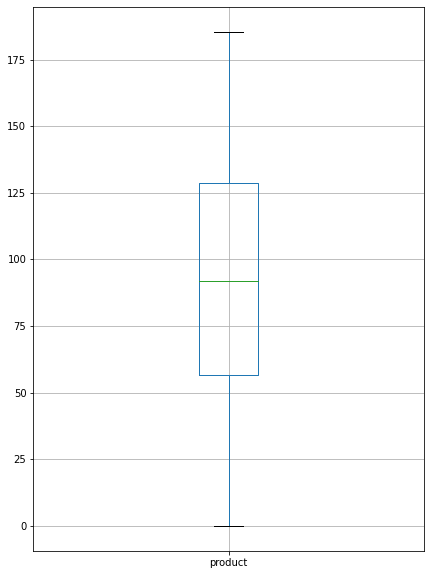

In [13]:
print(geo_data_0['product'].describe())
geo_data_0.boxplot('product', figsize = (7,10))

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


<AxesSubplot:>

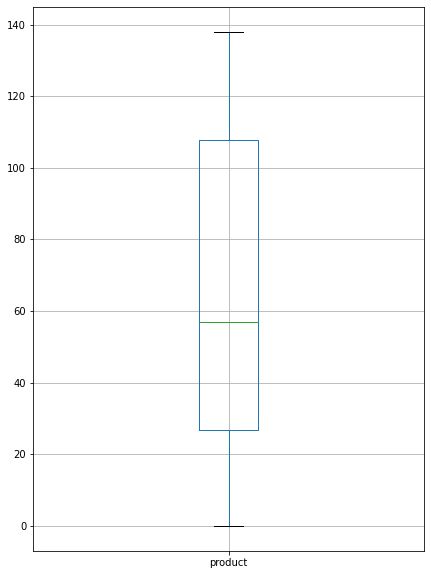

In [14]:
print(geo_data_1['product'].describe())
geo_data_1.boxplot('product', figsize = (7,10))

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


<AxesSubplot:>

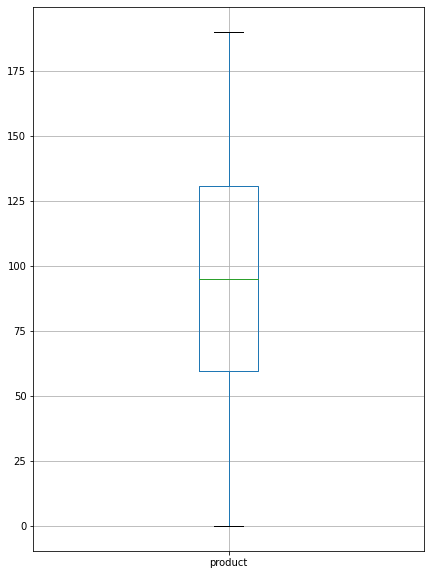

In [15]:
print(geo_data_2['product'].describe())
geo_data_2.boxplot('product', figsize = (7,10))

In [16]:
def check_zeros(df, target_name):
    zeros = df[df[target_name] == 0][target_name].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent*100)

In [17]:
check_zeros(geo_data_0, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 0.001


In [18]:
check_zeros(geo_data_1, 'product')

Количество нулевых значений - 8235
Процент нулевых значений - 8.235000000000001


In [19]:
check_zeros(geo_data_2, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 0.001


Удалим из каждого датафрейма столбец id. Он не несет значимости для модели.

In [20]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

### Вывод по шагу 1.

Данные готовы к исследованию. Они не содержат пропусков, дубликатов и аномальных значений, распределены нормально. Были удалены признаки, не влияющие на работу модели. 

Во втором регионе 8% составляют данные со значением product = 0.0. Попробуем сначала обучить модель без изменения данных. 


## Обучение и проверка модели <a id="2"></a>

Создадим функцию для:
- разделения данных на обучающую и валидационную выборки, 
- масштабирования признаков, 
- обучения модели, 
- подсчета rmse и среднего запаса сырья в скважинах.

Данные будут разбиты в соотношении 75:25. Целевой признак - product (объём запасов в скважине).

In [21]:
model = LinearRegression()

def lr_predict(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    numeric = ['f0', 'f1', 'f2']
    
    scaler = StandardScaler(with_mean=False)
    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data['predicted_product'].mean()
    ssum = data['predicted_product'].sum()
    return data, rmse, mean, ssum, target_train, target_valid

Произведем вывод предсказанного запаса с реальным и выведем RMSE.

In [22]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum, geo_data_0_target_train, geo_data_0_target_valid  = lr_predict(geo_data_0, 'product')
print(geo_data_0_predicted.head())
print('RMSE -', geo_data_0_rmse)
print('Средний запас сырья -', geo_data_0_predicted_mean)
print('Target shape:',  geo_data_0_target_train.shape, geo_data_0_target_valid.shape)

       real_product  predicted_product
71751     10.038645          95.894952
80493    114.551489          77.572583
2655     132.603635          77.892640
53233    169.072125          90.175134
91141    122.325180          70.510088
RMSE - 37.5794217150813
Средний запас сырья - 92.59256778438035
Target shape: (75000,) (25000,)


In [23]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum, geo_data_1_target_train, geo_data_1_target_valid  = lr_predict(geo_data_1, 'product')
print(geo_data_1_predicted.head())
print('RMSE -', geo_data_1_rmse)
print('Средний запас сырья -', geo_data_1_predicted_mean)
print('Target shape:',  geo_data_1_target_train.shape, geo_data_1_target_valid.shape)

       real_product  predicted_product
71751     80.859783          82.663314
80493     53.906522          54.431786
2655      30.132364          29.748760
53233     53.906522          53.552133
91141      0.000000           1.243856
RMSE - 0.893099286775617
Средний запас сырья - 68.72854689544602
Target shape: (75000,) (25000,)


In [24]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum, geo_data_2_target_train, geo_data_2_target_valid  = lr_predict(geo_data_2, 'product')
print(geo_data_2_predicted.head())
print('RMSE -', geo_data_2_rmse)
print('Средний запас сырья -', geo_data_2_predicted_mean)
print('Target shape:',  geo_data_1_target_train.shape, geo_data_1_target_valid.shape)

       real_product  predicted_product
71751     61.212375          93.599633
80493     41.850118          75.105159
2655      57.776581          90.066809
53233    100.053761         105.162375
91141    109.897122         115.303310
RMSE - 40.02970873393434
Средний запас сырья - 94.96504596800489
Target shape: (75000,) (25000,)


Скорее всего, утеряные данные из второго региона сказались на модели и она достаточно сильно переобучилась. Заменим нули в этом датафрейме медианным значением.

In [25]:
geo_data_1_1 = geo_data_1
geo_data_1_1['product'] = geo_data_1_1['product'].replace(0, np.nan).bfill()
m = geo_data_1_1['product'].median()
geo_data_1_1['product']  = geo_data_1_1['product'].fillna(m)

In [26]:
geo_data_1_1_predicted, geo_data_1_1_rmse, geo_data_1_1_predicted_mean, geo_data_1_1_predicted_sum, geo_data_1_1_target_train, geo_data_1_1_target_valid   = lr_predict(geo_data_1_1, 'product')
print(geo_data_1_1_predicted.head())
print('RMSE -', geo_data_1_1_rmse)
print('Средний запас сырья -', geo_data_1_1_predicted_mean)

       real_product  predicted_product
71751     80.859783          85.536014
80493     53.906522          66.976653
2655      30.132364          39.508559
53233     53.906522          69.504386
91141     26.953261          23.419217
RMSE - 21.40001920049716
Средний запас сырья - 74.93151918159673


In [27]:
print('Суммарный предсказанный запас в позиции 0 -', geo_data_0_predicted_sum)
print('Суммарный реальный запас в позиции 0 -', geo_data_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 1 -', geo_data_1_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', geo_data_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', geo_data_2_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', geo_data_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 0 - 2314814.194609509
Суммарный реальный запас в позиции 0 - 2301964.918520732

Суммарный предсказанный запас в позиции 1 - 1718213.6723861503
Суммарный реальный запас в позиции 1 - 1718078.4006089992

Суммарный предсказанный запас в позиции 2 - 2374126.1492001223
Суммарный реальный запас в позиции 2 - 2372105.8202213594


### Вывод по шагу 2.

Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы во втором регионе (RMSE - 21.4), далее в первом и третьем соотвественно.


 <div class="alert alert-block alert-info"> upd. RMSE = 0.893 </div>

## Подготовка к расчёту прибыли <a id="3"></a>

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [28]:
average_profit_per_point = BUDGET / BEST_LOCS
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'руб.')

average_barrels_per_point = average_profit_per_point  / PRICE_PER_BARREL
print('Средний объем нефти на точку -',average_barrels_per_point, 'баррелей')

average_barrels = BUDGET / PRICE_PER_BARREL
print('Средний объем нефти на регион -',average_barrels, 'баррелей')

Средняя прибыль на лучшую точку - 50000000.0 руб.
Средний объем нефти на точку - 111.11111111111111 баррелей
Средний объем нефти на регион - 22222.222222222223 баррелей


In [29]:
print('Средний запас фактичекой нефти на скважину в регионе 1', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', geo_data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 74.99090954446737
Средний запас фактичекой нефти на скважину в регионе 3 95.00000000000004


Создадим функцию для расчета прибыли на 500 разведанных точек.

In [30]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE_PER_BARREL * selected.sum() - BUDGET

### Вывод по шагу 3
Была подготовлена средняя оценка прибыли за скважину и средний объем на скважину, создана функция по расчету прибыли.

Изучены средние фактические запасы. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

Во вторых данных значений больше 111 достаточно много, возможно, судить о прибыльности по среднему значению запасов во всем регионе рано.

## Расчёт прибыли и рисков <a id="4"></a>

In [31]:
state = np.random.RandomState(12345)
def bs_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=CHOSEN_LOCS)
        probs_sample = probs[target_sample.index]
        rev = revenue(target, probs_sample, BEST_LOCS)
        if rev < 0:
            lost +=1
        values.append(rev)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [32]:
average_0, lower_0, upper_0, risk_0 = bs_1000(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 396164984.80 руб.
95% доверительный интервал от -111215545.89 до 909766941.55 руб.
Процент риска 6.90%


In [33]:
average_1, lower_1, upper_1, risk_1 = bs_1000(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по второму региону.')
print('Средняя прибыль по региону = {:.2f} руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по второму региону.
Средняя прибыль по региону = 461155817.28 руб.
95% доверительный интервал от 78050810.75 до 862952060.26 руб.
Процент риска 0.70%


In [34]:
average_2, lower_2, upper_2, risk_2 = bs_1000(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по третьему региону.')
print('Средняя прибыль по региону = {:.2f} руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по третьему региону.
Средняя прибыль по региону = 392950475.17 руб.
95% доверительный интервал от -112227625.38 до 934562914.55 руб.
Процент риска 6.50%


### Вывод по шагу 4.

Данные были обработаны и рассчитаны прибыль, интервал и риски.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 

Мы отсеиваем первый и третий регион, так как риски достаточно велики. Остается второй регион, чей риск ниже порогового значения. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

## Общий вывод <a id="5"></a>

В ходе исследования данные были подготовлены для обучения модели, удалены столбцы, не имеющие значимость, нулевые значения заполнены медианным.

Модель линейной регрессии обучена и применена для каждого региона geo_data_0, geo_data_1 и geo_data_2. 

С процентом риска, равным 1.3% определён регион, где добыча принесёт наибольшую прибыль - geo_data_1 (предполагаемая средняя прибыль по региону = 418 миллионов рублей).  В двух других регионах вероятность убытков больше 6%, их не стоит рассматривать в качестве потенциальных мест бурения новых скважин.

<div class="alert alert-block alert-info">upd. процент риска 0.7%, прибыль 461 млн. р.</div>